#### Step 1: Build the Static Subject Table

What it does:
Loads subject-level data (e.g., subject-info.csv), cleans it, and constructs the base dataframe keyed by id.

Key operations (typical here):

One-hot encode nominal categoricals (e.g., gender, ethnicity).

Ordinal-encode ordered categoricals (e.g., education).

Convert birth_year to age.

Keep only one row per subject.

Why it matters:
This is the anchor table. Everything else merges back to this by id.

In [56]:
import pandas as pd
from datetime import datetime

print("--- Running Step 1: Create Base Dataframe (Static Features) ---")

# --- 1. Load Data ---
try:
    # Load the subject-info.csv file
    static_df = pd.read_csv('subject-info.csv')
except FileNotFoundError:
    print("Error: 'subject-info.csv' not found. Please ensure it's in the same directory.")
    # In a real script, you would exit here
    # exit()
except Exception as e:
    print(f"An error occurred loading the file: {e}")
    # exit()

if 'static_df' in locals():
    # Set 'id' as the index. This is crucial for merging all other features later.
    if 'id' in static_df.columns:
        # Ensure index is a string, as all other 'id' cols will be read as strings
        static_df['id'] = static_df['id'].astype(str)
        static_df = static_df.set_index('id')
    else:
        print("Error: 'id' column not found. Cannot set index.")
        # exit()

    # --- 2. Process Static Numerics ---
    
    # Use 2024 as the reference year as per your instructions
    current_year = 2024 
    
    if 'birth_year' in static_df.columns:
        # Calculate 'age' from 'birth_year'
        static_df['age'] = current_year - static_df['birth_year']
        print(f"Calculated 'age' based on the year {current_year}.")
    else:
        print("Warning: 'birth_year' column not found. Cannot calculate 'age'.")
    
    # 'age_of_first_menarche' is already numeric and static, so we'll keep it as is.

    # --- 3. Encode Ordinal Variables (Label Encoding) ---
    
    if 'education' in static_df.columns:
        # We must define an explicit order for ordinal data.
        # This mapping is an assumption to show the process.
        education_map = {
            'Less than High School': 0,
            'High School': 1,
            'Some College': 2,
            "Bachelor's Degree": 3,
            "Graduate Degree": 4,
            # Add other values you find, e.g., 'Prefer not to say': -1
        }
        
        static_df['education_ordinal'] = static_df['education'].map(education_map)
        print("Mapped 'education' to 'education_ordinal'.")
        
        # Check for any values that didn't get mapped (which will be NaN)
        unmapped_edu = static_df[static_df['education_ordinal'].isna()]['education'].unique()
        if len(unmapped_edu) > 0:
            print(f"  Warning: Found unmapped 'education' values: {unmapped_edu}")
            # We'll fill these with a placeholder, e.g., -1 for 'unspecified'
            static_df['education_ordinal'].fillna(-1, inplace=True)
    else:
        print("Warning: 'education' column not found. Skipping ordinal mapping.")
    
    # You would repeat this for 'self_report_menstrual_health_literacy' if you have a clear order.
    # For now, we'll treat it as nominal in the next step.

    # --- 4. Encode Nominal Variables (One-Hot Encoding) ---
    
    # List of columns to one-hot encode.
    nominal_cols = []
    for col in ['ethnicity', 'gender', 'sexually_active', 'self_report_menstrual_health_literacy']:
        if col in static_df.columns:
            nominal_cols.append(col)
        
    if nominal_cols:
        print(f"One-hot encoding nominal columns: {nominal_cols}")
        # Use pd.get_dummies for one-hot encoding
        static_df = pd.get_dummies(static_df, columns=nominal_cols, drop_first=True, dtype=int)
    else:
        print("No nominal columns found to encode.")

    # --- 5. Clean Up ---
    
    # Drop the original columns that have been processed
    columns_to_drop = [
        'birth_year',  # Replaced by 'age'
        'education'    # Replaced by 'education_ordinal'
    ]
    
    # Drop columns, handling errors if a column wasn't found
    final_static_df = static_df.drop(columns=columns_to_drop, errors='ignore')
    
    # Display the result
    print("\n--- Final Static Features DataFrame (final_static_df) ---")
    print(final_static_df.head())
    
    print("\n--- DataFrame Info ---")
    final_static_df.info()

    # This 'final_static_df' is now ready for the next steps.

--- Running Step 1: Create Base Dataframe (Static Features) ---
Calculated 'age' based on the year 2024.
Mapped 'education' to 'education_ordinal'.
 "Bachelor's degree (e.g. BA, BS)" 'Doctorate or professional degree'
 'High school degree or equivalent (e.g. GED)'
 "Master's degree (e.g. MA, MS, MEd)"]
One-hot encoding nominal columns: ['ethnicity', 'gender', 'sexually_active', 'self_report_menstrual_health_literacy']

--- Final Static Features DataFrame (final_static_df) ---
    age_of_first_menarche  age  education_ordinal  ethnicity_Caribbean  \
id                                                                       
1                      14   25               -1.0                    0   
2                      13   29               -1.0                    0   
3                      12   24               -1.0                    0   
4                      12   24               -1.0                    0   
6                      13   27               -1.0                    0   



/var/folders/3z/vwc9kzfd10z1qlyr3sxw9w6r0000gn/T/ipykernel_74216/148075304.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  static_df['education_ordinal'].fillna(-1, inplace=True)


#### Step 2: Engineer Features from Continuous Time Series

What it does:
Reads wearable/physio timelines (heart rate, steps, glucose, etc.) and aggregates per subject into compact features.

Key operations (typical here):

Group by id.

Descriptive stats (mean/median/std/min/max/range/skew/kurtosis).

Simple temporal structure (trend via linear slope; lag-1 autocorrelation).

Optional spectral features (FFT) or tsfresh-style summaries.

Produces one features table per sensor; all rows = subjects.

Why it matters:
Turns long, irregular time series into a consistent row of numbers per person.

In [58]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

print("--- Running Step 2: Feature Engineering for Continuous Longitudinal Data ---")

# --- 1. Helper Functions ---

def trend(x):
    """Calculates the slope of a linear trend in the time series."""
    try:
        x_clean = x.dropna().reset_index(drop=True)
        if len(x_clean) < 2:
            return 0.0
        
        t = np.arange(len(x_clean))
        # Check for constant data
        if np.all(x_clean == x_clean.iloc[0]):
             return 0.0
             
        coeff = np.polyfit(t, x_clean, 1)
        return coeff[0]
    except Exception:
        return np.nan # Return NaN on any failure

def lag1_autocorr(x):
    """Calculates the lag-1 autocorrelation."""
    try:
        x_clean = x.dropna()
        if len(x_clean) < 2:
            return 0.0
        # Check for constant data
        if x_clean.std() == 0:
            return 0.0 # No variance, so no autocorrelation
        
        autocorr = x_clean.autocorr(lag=1)
        # autocorr can return NaN if std is 0, handle that
        return 0.0 if pd.isna(autocorr) else autocorr
    except Exception:
        return np.nan

def spectral_power(x):
    """Calculates the sum of power in the first 3 frequency components."""
    try:
        x_clean = x.dropna()
        if len(x_clean) < 2:
            return 0.0
        
        # Calculate FFT (Fast Fourier Transform)
        fft_vals = np.abs(np.fft.fft(x_clean))
        
        # Get power (sum of the first few components, excluding the 0-freq DC component)
        power = np.sum(fft_vals[1:4])
        return power
    except Exception:
        return np.nan

# --- 2. Main Feature Calculation Function ---

def calculate_features(x):
    """
    Calculates a set of features for a given pandas Series (time series).
    Returns a pandas Series (or dictionary) of features.
    """
    x_clean = x.dropna()
    if x_clean.empty:
        # Return a series of NaNs if no data
        return pd.Series({
            'mean': np.nan, 'median': np.nan, 'std': np.nan, 'var': np.nan,
            'min': np.nan, 'max': np.nan, 'skew': np.nan, 'kurt': np.nan,
            'range': np.nan, 'trend': np.nan, 'lag1_autocorr': np.nan,
            'spectral_power': np.nan
        })

    # Descriptive Statistics
    features = {
        'mean': x_clean.mean(),
        'median': x_clean.median(),
        'std': x_clean.std(),
        'var': x_clean.var(),
        'min': x_clean.min(),
        'max': x_clean.max(),
        'skew': x_clean.skew(),
        'kurt': x_clean.kurtosis(),
        'range': x_clean.max() - x_clean.min()
    }
    
    # Temporal Features
    features['trend'] = trend(x_clean)
    features['lag1_autocorr'] = lag1_autocorr(x_clean)
    
    # Spectral Features
    features['spectral_power'] = spectral_power(x_clean)
    
    return pd.Series(features)

# --- 3. Configuration: Files & Columns to Process ---

# This is the "control panel" for the script.
# We've omitted columns that contain JSON or are purely categorical.
continuous_files_config = {
    'sleep_score.csv': ['composition_score', 'deep_sleep_in_minutes', 'duration_score', 'overall_score', 'resting_heart_rate', 'restlessness', 'revitalization_score'],
    'wrist_temperature.csv': ['temperature_diff_from_baseline'],
    'stress_score.csv': ['exertion_points', 'responsiveness_points', 'sleep_points', 'stress_score'],
    'computed_temperature.csv': ['nightly_temperature'],
    'demographic_vo2_max.csv': ['demographic_vo2_max', 'filtered_demographic_vo2_max'],
    'estimated_oxygen_variation.csv': ['infrared_to_red_signal_ratio'],
    'exercise.csv': ['activeduration', 'averageheartrate', 'calories', 'duration', 'elevationgain', 'steps'], # 'activezoneminutes' omitted (it's JSON)
    'heart_rate_variability_details.csv': ['coverage', 'high_frequency', 'low_frequency', 'rmssd'],
    'calories.csv': ['calories'],
    'time_in_heart_rate_zones.csv': ['below_default_zone_1', 'in_default_zone_1', 'in_default_zone_2', 'in_default_zone_3'],
    'respiratory_rate_summary.csv': ['deep_sleep_breathing_rate', 'full_sleep_breathing_rate', 'light_sleep_breathing_rate', 'rem_sleep_breathing_rate'],
    'heart_rate.csv': ['bpm', 'confidence'],
    'active_minutes.csv': ['lightly', 'moderately', 'sedentary', 'very'],
    'distance.csv': ['distance'],
    'resting_heart_rate.csv': ['value'], # 'error' column is omitted
    'altitude.csv': ['altitude'],
    'sleep.csv': ['duration', 'efficiency', 'minutesafterwakeup', 'minutesasleep', 'minutesawake', 'minutestofallasleep', 'timeinbed'],
    'steps.csv': ['steps'],
    'hormones_and_selfreport.csv': ['estrogen', 'lh', 'pdg'],
    'glucose.csv': ['glucose_value'],
    'active_zone_minutes.csv': ['total_minutes']
}

# --- 4. Main Processing Loop ---

all_features_dfs = []
# Get the master list of all 42 subject IDs from your static file
# This ensures even subjects with NO longitudinal data are included (as all-NaN rows)
all_subject_ids = final_static_df.index

for filename, columns in continuous_files_config.items():
    print(f"Processing '{filename}'...")
    
    try:
        # Load the CSV, ensuring 'id' is read as a string
        df = pd.read_csv(filename, usecols=['id'] + columns, dtype={'id': str})
        
        # Drop rows where 'id' is missing
        df = df.dropna(subset=['id'])
        
        # Group by subject ID
        grouped = df.groupby('id')
        
        # List to hold feature DFs for this *file*
        file_features_list = []
        
        # Apply feature calculation to each column
        for col in columns:
            # .apply() runs 'calculate_features' for each group's Series
            col_features_series = grouped[col].apply(calculate_features)
            
            # .unstack() pivots the feature names (mean, std) into columns
            col_features_df = col_features_series.unstack()
            
            # Rename columns to be unique, e.g., 'bpm_mean', 'bpm_std'
            col_features_df = col_features_df.add_prefix(f"{col}_")
            
            file_features_list.append(col_features_df)
            
        # Combine all feature DFs for this file (horizontally)
        file_features_df = pd.concat(file_features_list, axis=1)
        
        # Reindex to match the master list of 42 subjects.
        # This adds all-NaN rows for subjects who were not in this file.
        file_features_df = file_features_df.reindex(all_subject_ids)
        
        all_features_dfs.append(file_features_df)
        print(f"  ...Done. Created {file_features_df.shape[1]} features.")

    except FileNotFoundError:
        print(f"  Warning: File '{filename}' not found. Skipping.")
    except ValueError as e:
        print(f"  Warning: Error processing '{filename}'. Check 'usecols' or column names. Error: {e}")
    except Exception as e:
        print(f"  An unexpected error occurred with '{filename}': {e}")


# --- 5. Final Merge ---

if all_features_dfs:
    # Combine all the feature dataframes from all files (horizontally)
    # They all share the 'id' index (all 42 subjects).
    continuous_features_df = pd.concat(all_features_dfs, axis=1)
    
    print("\n--- Step 2 Complete: Continuous Feature Engineering ---")
    print(f"Total subjects (rows): {continuous_features_df.shape[0]}")
    print(f"Total continuous features (columns): {continuous_features_df.shape[1]}")
    
    print("\n--- continuous_features_df.info() ---")
    # .info() will show how many subjects have non-null data for each feature
    continuous_features_df.info()

    print("\n--- continuous_features_df.head() ---")
    print(continuous_features_df.head())
    
    # This DataFrame is now ready for Step 3.
else:
    print("\nNo continuous features were generated. Check file paths and 'continuous_files_config' config.")

--- Running Step 2: Feature Engineering for Continuous Longitudinal Data ---
Processing 'sleep_score.csv'...
  ...Done. Created 84 features.
Processing 'wrist_temperature.csv'...
  ...Done. Created 12 features.
Processing 'stress_score.csv'...
  ...Done. Created 48 features.
Processing 'computed_temperature.csv'...
  ...Done. Created 12 features.
Processing 'demographic_vo2_max.csv'...
  ...Done. Created 24 features.
Processing 'estimated_oxygen_variation.csv'...
  ...Done. Created 12 features.
Processing 'exercise.csv'...
  ...Done. Created 72 features.
Processing 'heart_rate_variability_details.csv'...
  ...Done. Created 48 features.
Processing 'calories.csv'...
  ...Done. Created 12 features.
Processing 'time_in_heart_rate_zones.csv'...
  ...Done. Created 48 features.
Processing 'respiratory_rate_summary.csv'...
  ...Done. Created 48 features.
Processing 'heart_rate.csv'...
  ...Done. Created 24 features.
Processing 'active_minutes.csv'...
  ...Done. Created 48 features.
Processing 

#### Step 3: Engineer Features from Categorical Time Series

What it does:
Summarizes daily categorical signals (e.g., cycle phase, self-report states) into interpretable per-subject features.

Key operations (visible fragments):

Proportions via one-hot + mean (the mean of a dummy is the time-in-state).

Entropy function is defined to measure sequence unpredictability.

(Optionally) Transition rates or matrices.

Why it matters:
You can’t average categories. Proportions/entropy capture behavior and regularity without throwing away information.

In [60]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

print("--- Running Step 3: Feature Engineering for Categorical Longitudinal Data ---")

# --- 1. Helper Functions ---

def calculate_proportions(group):
    """
    Calculates the proportion of time spent in each unique state.
    Uses pd.get_dummies and then takes the mean.
    """
    group_clean = group.dropna()
    if group_clean.empty:
        return pd.Series(dtype=float) # Return empty series if all-NaN
        
    # Get one-hot encoded
    dummies = pd.get_dummies(group_clean)
    # The mean of a one-hot column is its proportion
    proportions = dummies.mean()
    return proportions

def calculate_entropy(group):
    """Calculates the Shannon entropy of the value counts."""
    group_clean = group.dropna()
    if group_clean.empty or len(group_clean.unique()) <= 1:
        # Return NaN if no data, or 0.0 if only one state (no uncertainty)
        return np.nan if group_clean.empty else 0.0 
        
    counts = group_clean.value_counts()
    return entropy(counts)

def calculate_transition_rate(group):
    """Calculates the proportion of time the state changes from the previous entry."""
    group_clean = group.dropna().reset_index(drop=True)
    if len(group_clean) < 2:
        # Cannot have transitions with < 2 data points
        return np.nan if group_clean.empty else 0.0
        
    # Compares this row (group_clean) to the previous row (group_clean.shift(1))
    transitions = (group_clean != group_clean.shift(1)).sum()
    
    # We ignore the first entry (which is NaN after shift), so we sum and divide by (n-1)
    return transitions / (len(group_clean) - 1)

# --- 2. Configuration: Files & Columns to Process ---

# This is the "control panel" for categorical columns.
# We're also adding 'is_weekend' from one file as a representative.
categorical_files_config = {
    'stress_score.csv': ['calculation_failed', 'status'],
    'computed_temperature.csv': ['type'],
    'exercise.csv': ['activityname', 'logtype', 'manualvaluesspecified', 'hasgps', 'hasactivezoneminutes'],
    'sleep.csv': ['infocode', 'mainsleep', 'type'],
    'hormones_and_selfreport.csv': [
        'appetite', 'bloating', 'cramps', 'exerciselevel', 'fatigue', 
        'flow_color', 'flow_volume', 'foodcravings', 'headaches', 
        'indigestion', 'moodswing', 'sleepissue', 'sorebreasts', 'stress', 'phase'
    ],
    'steps.csv': ['is_weekend'] # Using 'is_weekend' from one file
}

# --- 3. Main Processing Loop ---

all_features_dfs = []
# Get the master list of all 42 subject IDs from your static file
# This ensures even subjects with NO longitudinal data are included (as all-NaN rows)
all_subject_ids = final_static_df.index

for filename, columns in categorical_files_config.items():
    print(f"Processing '{filename}'...")
    
    try:
        # Load the data, always including 'id'
        df = pd.read_csv(filename, usecols=['id'] + columns, dtype={'id': str})
        
        # Drop rows where 'id' is missing
        df = df.dropna(subset=['id'])
        
        # Group by subject
        grouped = df.groupby('id')
        
        for col in columns:
            # === Feature 1: Proportions ===
            # This returns multiple columns (e.g., phase_prop_luteal, phase_prop_follicular)
            proportions_df = grouped[col].apply(calculate_proportions).unstack(fill_value=0)
            # Add prefix to all new proportion columns
            proportions_df = proportions_df.add_prefix(f"{col}_prop_")
            all_features_dfs.append(proportions_df)
            
            # === Feature 2: Entropy ===
            entropy_df = grouped[col].apply(calculate_entropy).to_frame(name=f"{col}_entropy")
            all_features_dfs.append(entropy_df)
            
            # === Feature 3: Transition Rate ===
            transition_df = grouped[col].apply(calculate_transition_rate).to_frame(name=f"{col}_transition_rate")
            all_features_dfs.append(transition_df)

        print(f"  ...Done processing {len(columns)} categorical columns.")

    except FileNotFoundError:
        print(f"  Warning: File '{filename}' not found. Skipping.")
    except ValueError as e:
        print(f"  Warning: Error processing '{filename}'. Check 'usecols'. Error: {e}")
    except Exception as e:
        print(f"  An unexpected error occurred with '{filename}': {e}")

# --- 4. Final Merge ---

if all_features_dfs:
    # Concatenate all features horizontally. They all share the 'id' index.
    categorical_features_df = pd.concat(all_features_dfs, axis=1)
    
    # Reindex to match the master list of 42 subjects.
    # This adds all-NaN rows for subjects who were not in these files.
    categorical_features_df = categorical_features_df.reindex(all_subject_ids)
    
    # Clean up column names that might contain problematic characters
    categorical_features_df.columns = categorical_features_df.columns.astype(str).str.replace(r'[^A-Za-z0-9_]+', '', regex=True)

    print("\n--- Step 3 Complete: Categorical Feature Engineering ---")
    
    print("\n--- categorical_features_df.info() ---")
    categorical_features_df.info()
    
    print("\n--- categorical_features_df.head() ---")
    print(categorical_features_df.head())
    
    # This DataFrame is now ready for Step 4.

else:
    print("\nNo categorical features were generated.")

--- Running Step 3: Feature Engineering for Categorical Longitudinal Data ---
Processing 'stress_score.csv'...
  ...Done processing 2 categorical columns.
Processing 'computed_temperature.csv'...
  ...Done processing 1 categorical columns.
Processing 'exercise.csv'...
  ...Done processing 5 categorical columns.
Processing 'sleep.csv'...
  ...Done processing 3 categorical columns.
Processing 'hormones_and_selfreport.csv'...
  ...Done processing 15 categorical columns.
Processing 'steps.csv'...
  ...Done processing 1 categorical columns.

--- Step 3 Complete: Categorical Feature Engineering ---

--- categorical_features_df.info() ---
<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 1 to 50
Columns: 197 entries, calculation_failed_prop_False to is_weekend_transition_rate
dtypes: float64(197)
memory usage: 66.0+ KB

--- categorical_features_df.head() ---
    calculation_failed_prop_False  calculation_failed_prop_True  \
id                                                            

#### Step 4: Merge Everything and Impute Missing Values

What it does:
Combines static, continuous, and categorical feature tables into one wide matrix and fills in gaps.

Key operations (visible fragments):

Merge on id.

IterativeImputer from scikit-learn to impute continuous features using multivariate relationships.

(If present) sensible handling of categorical NA (mode/model-based) before one-hot.

Why it matters:
Prevents clustering on “who has missing data” instead of real physiology/behavior.

In [62]:
import pandas as pd
import numpy as np
# We need to enable the experimental IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

print("--- Running Step 4: Handle Missing Values ---")

try:
    # --- 1. Merge All Feature DataFrames ---
    
    # Ensure all indices are strings for a clean join
    final_static_df.index = final_static_df.index.astype(str)
    continuous_features_df.index = continuous_features_df.index.astype(str)
    categorical_features_df.index = categorical_features_df.index.astype(str)

    # Join all three dataframes on their 'id' index.
    # We use 'inner' to ensure we only have the 42 subjects from the static file.
    features_part1 = final_static_df.join(continuous_features_df, how='inner')
    final_features_df = features_part1.join(categorical_features_df, how='inner')

    print(f"Successfully merged all features.")
    print(f"Initial shape of final_features_df: {final_features_df.shape}")

except NameError as e:
    print(f"Error: A required DataFrame is missing: {e}")
    print("Please re-run the previous scripts to create 'final_static_df', 'continuous_features_df', and 'categorical_features_df'.")
    # In a real script, you would exit here
    # exit()

if 'final_features_df' in locals():
    
    # --- 2. Diagnose Missingness ---
    print("\n--- Missing Data Diagnosis ---")
    missing_percent = final_features_df.isna().mean().sort_values(ascending=False)
    
    print("Top 20 most-missing features (% missing):")
    print((missing_percent.head(20) * 100).round(2))
    
    # --- 3. Drop Sparse Features ---
    
    # Identify columns to drop (missing > 80%)
    threshold = 0.80
    cols_to_drop = missing_percent[missing_percent > threshold].index.tolist()
    
    if cols_to_drop:
        print(f"\nDropping {len(cols_to_drop)} features with >{threshold*100}% missing data.")
        print(cols_to_drop)
        features_to_impute_df = final_features_df.drop(columns=cols_to_drop)
    else:
        print(f"\nNo features found with >{threshold*100}% missing data. Proceeding with all features.")
        features_to_impute_df = final_features_df.copy()
        
    print(f"Shape before imputation: {features_to_impute_df.shape}")
    
    # --- 4. Impute Multivariately ---
    
    print("\nStarting IterativeImputer...")
    # This may take a minute.
    
    # IterativeImputer works on numeric data. Our dataframes are all numeric.
    # (bools from static_df, floats from continuous_df, floats from categorical_df)
    
    # Keep track of column names and index
    original_columns = features_to_impute_df.columns
    original_index = features_to_impute_df.index
    
    # Initialize the imputer
    imputer = IterativeImputer(random_state=42, max_iter=10)
    
    # Fit and transform the data. This returns a NumPy array.
    imputed_data_array = imputer.fit_transform(features_to_impute_df)
    
    print("Imputation complete.")
    
    # --- 5. Create Final Imputed DataFrame ---
    
    # Convert the NumPy array back into a pandas DataFrame
    imputed_features_df = pd.DataFrame(
        imputed_data_array, 
        columns=original_columns, 
        index=original_index
    )
    
    print(f"Final imputed feature matrix shape: {imputed_features_df.shape}")
    
    print("\n--- imputed_features_df.info() ---")
    # This .info() should show 42 non-null entries for all columns
    imputed_features_df.info()
    
    print("\n--- imputed_features_df.head() ---")
    print(imputed_features_df.head())
    
    # This DataFrame is now 100% complete and ready for Step 5.

--- Running Step 4: Handle Missing Values ---
Successfully merged all features.
Initial shape of final_features_df: (42, 901)

--- Missing Data Diagnosis ---
Top 20 most-missing features (% missing):
pdg_max                                 52.38
pdg_median                              52.38
pdg_range                               52.38
pdg_kurt                                52.38
pdg_skew                                52.38
pdg_min                                 52.38
pdg_var                                 52.38
pdg_std                                 52.38
pdg_mean                                52.38
pdg_lag1_autocorr                       52.38
pdg_spectral_power                      52.38
pdg_trend                               52.38
duration_trend                          26.19
hasactivezoneminutes_transition_rate    26.19
duration_lag1_autocorr                  26.19
duration_spectral_power                 26.19
elevationgain_mean                      26.19
elevationgain_medi

#### Step 5: Scale Features and Reduce Dimensions (PCA)

What it does:
Normalizes all numeric columns (except id) and applies PCA to de-noise and remove redundancy.

Key operations (visible fragments):

StandardScaler → zero mean, unit variance.

PCA with variance-based component retention (e.g., 80–90%).

Why it matters:
K-means is scale-sensitive. PCA stabilizes and speeds clustering while keeping the signal.

In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("--- Running Step 5: Scale and Reduce (PCA) ---")

try:
    # We assume 'imputed_features_df' is in memory from Step 4.
    
    # --- 1. Scale Data ---
    print("Scaling all features with StandardScaler...")
    
    # Keep the 'id' (index) for later
    subject_ids = imputed_features_df.index
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Fit and transform the imputed data
    scaled_data = scaler.fit_transform(imputed_features_df)
    
    print("Scaling complete.")

    # --- 2. Dimensionality Reduction (PCA) ---
    print("Running PCA to retain 90% of variance...")
    
    # Initialize PCA to automatically find the number of components
    # that explain 90% of the variance.
    pca = PCA(n_components=0.90)
    
    # Fit and transform the scaled data
    pca_data = pca.fit_transform(scaled_data)
    
    print("PCA complete.")
    
    # --- 3. Analyze PCA Results ---
    print("\n--- PCA Analysis ---")
    print(f"Original number of features: {scaled_data.shape[1]}")
    print(f"New number of components: {pca.n_components_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
    
    # Create a new DataFrame for the PCA-transformed data
    pca_df = pd.DataFrame(
        data=pca_data,
        columns=[f'PC{i+1}' for i in range(pca_data.shape[1])],
        index=subject_ids
    )
    
    print("\n--- pca_df.head() ---")
    print(pca_df.head())
    
    # This 'pca_df' is now ready for Step 6: Clustering.

except NameError as e:
    print(f"Error: A required DataFrame is missing: {e}")
    print("Please re-run the previous script (Step 4) to create 'imputed_features_df'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Running Step 5: Scale and Reduce (PCA) ---
Scaling all features with StandardScaler...
Scaling complete.
Running PCA to retain 90% of variance...
PCA complete.

--- PCA Analysis ---
Original number of features: 901
New number of components: 27
Total variance explained: 90.07%

--- pca_df.head() ---
          PC1        PC2        PC3        PC4        PC5       PC6       PC7  \
id                                                                              
1  -28.737476  38.546717  35.757956   0.952516   1.425616 -0.330308 -3.336643   
2   -8.968929 -13.306103   3.826625 -11.376624  -2.126812  2.845817 -0.561316   
3  -13.524086   3.544352  -3.864820   2.460976  -2.367983 -3.555577 -1.615152   
4  -11.224132 -13.518769   8.439726  19.761923   5.033600  7.236728  5.116502   
6  -10.204901   0.054411  -4.994202  -2.513419 -12.076368 -7.202015  3.232333   

          PC8        PC9       PC10  ...      PC18      PC19      PC20  \
id                                   ...              

#### Step 6: Cluster on PCA Embeddings

What it does:
Runs k-means on the PCA scores; optionally evaluates fits.

Key operations (typical here):

Fit KMeans(n_clusters=k, random_state=42) on PCA data.

Store clusters labels aligned to id.

(Often) elbow or silhouette calculation to choose k.

Why it matters:
This is where subjects are grouped into phenotypes based on all engineered signals.

--- Running Step 6: Cluster ---
Calculating Elbow Method and Silhouette Scores...
Displaying Elbow Method plot. Look for the 'elbow' point.


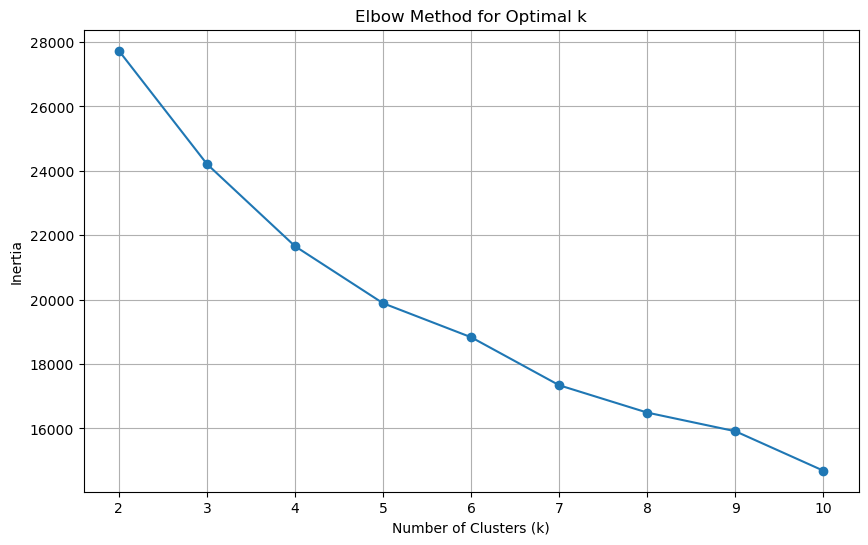

Displaying Silhouette Score plot. Look for the highest score.


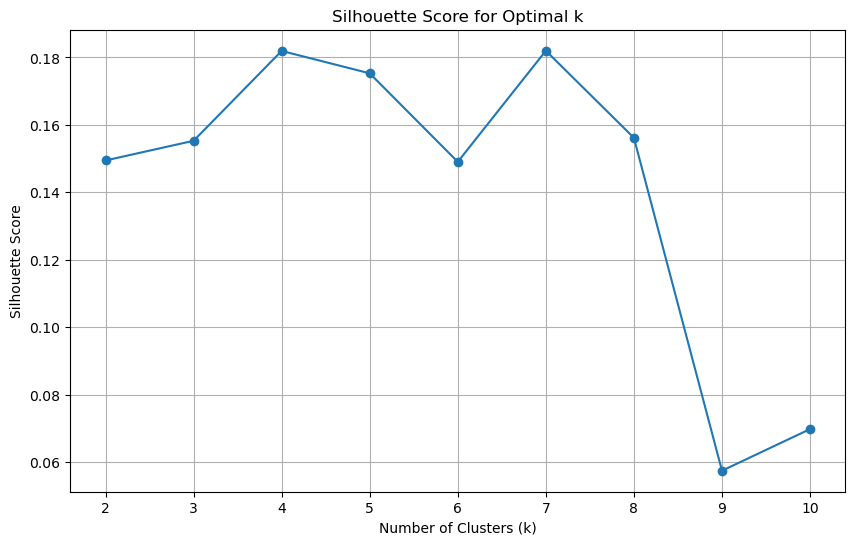


Running final K-Means with k=5...
Analyzing cluster results...

Added cluster assignments to 'results_df'.

--- Cluster Assignments (Head) ---
    cluster
id         
1         2
2         4
3         1
4         1
6         1

--- Cluster Sizes ---
cluster
0    20
1    14
4     5
3     2
2     1
Name: count, dtype: int64

--- Analysis: Mean values of Key Features by Cluster ---
               age  age_of_first_menarche   bpm_mean   steps_mean  steps_mean  \
cluster                                                                         
0        21.950000              11.800000  79.702796  6846.583960   12.140521   
1        23.285714              12.142857  78.590479  3047.997335   11.452582   
2        25.000000              14.000000  95.509730  1843.156716    9.733379   
3        22.500000              12.000000  82.185215  4975.351563    9.375856   
4        25.200000              11.400000  80.063371  5167.239877   11.352329   

         stress_score_mean  overall_score_mean  g

In [74]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

print("--- Running Step 6: Cluster ---")

try:
    # We assume 'pca_df' (from Step 5) and 'final_static_df' (from Step 1)
    # are in memory.
    
    data_to_cluster = pca_df

    # --- 1. Determine Optimal 'k' (Elbow Method & Silhouette Score) ---
    
    inertias = []
    silhouette_scores = []
    
    # We'll test a range of k values, e.g., from 2 to 10.
    k_range = range(2, 11) 
    
    print("Calculating Elbow Method and Silhouette Scores...")
    
    for k in k_range:
        kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_model.fit(data_to_cluster)
        
        # Elbow Method: Inertia (Sum of squared distances)
        inertias.append(kmeans_model.inertia_)
        
        # Silhouette Score
        labels = kmeans_model.labels_
        silhouette_avg = silhouette_score(data_to_cluster, labels)
        silhouette_scores.append(silhouette_avg)

    # --- Plot the Elbow Method ---
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range)
    plt.grid(True)
    print("Displaying Elbow Method plot. Look for the 'elbow' point.")
    #  # <-- Corrected: Commented out
    plt.show()

    # --- Plot the Silhouette Score ---
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range)
    plt.grid(True)
    print("Displaying Silhouette Score plot. Look for the highest score.")
    # 

 # <-- Corrected: Commented out
    plt.show()

    # --- 2. Run K-Means with Chosen 'k' ---
    
    # Based on the plots, you must choose a 'k'.
    # !IMPORTANT: You MUST change this value based on your plots!
    optimal_k = 5 # This is an assumption
    
    print(f"\nRunning final K-Means with k={optimal_k}...")
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data_to_cluster)
    
    # 'clusters' is now an array [0, 2, 1, 0, 3, ...] with the cluster for each subject.

    # --- 3. Analyze Results ---
    
    print("Analyzing cluster results...")
    
    # Create a new DataFrame for analysis
    # We use 'imputed_features_df' (from Step 4) to see the feature values
    # And 'final_static_df' (from Step 1) for the original demographics
    
    # Add cluster labels to the static data
    results_df = final_static_df.copy()
    results_df['cluster'] = clusters
    
    # Add cluster labels to the full imputed feature matrix
    # This lets us find the "mean" of 'bpm_mean' for each cluster
    profile_df = imputed_features_df.copy()
    profile_df['cluster'] = clusters

    print(f"\nAdded cluster assignments to 'results_df'.")

    print("\n--- Cluster Assignments (Head) ---")
    print(results_df[['cluster']].head())
    
    print("\n--- Cluster Sizes ---")
    print(results_df['cluster'].value_counts())

    print("\n--- Analysis: Mean values of Key Features by Cluster ---")
    
    # We can group the full profile_df by cluster and find the mean
    cluster_profile = profile_df.groupby('cluster').mean()
    
    # Let's look at a few key features we engineered
    key_features = [
        'age', 
        'age_of_first_menarche', 
        'bpm_mean', 
        'steps_mean',
        'stress_score_mean',
        'overall_score_mean',
        'glucose_value_mean',
        'phase_prop_Luteal', # Example categorical feature
        'moodswing_entropy' # Example categorical feature
    ]
    
    # Filter for key features that actually exist in our profile
    existing_key_features = [col for col in key_features if col in cluster_profile.columns]
    
    print(cluster_profile[existing_key_features])
    
    # This 'results_df' and 'cluster_profile' can now be used
    # for deep interpretation.

except NameError as e:
    print(f"Error: A required DataFrame is missing: {e}")
    print("Please ensure 'pca_df', 'final_static_df', and 'imputed_features_df' exist from previous steps.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

#### Step 7: Per-Feature ANOVA (F-test) and Export

What it does:
Computes F-scores and p-values for each feature across clusters and writes out the ranking.

Key operations (visible fragments):

f_oneway per feature using cluster partitions.

Sort by F and p.

Save cluster_feature_importance.csv.

Why it matters:
Gives a ranked list of what actually separates clusters. This guards against hand-wavy interpretations.

In [76]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import warnings

# Suppress warnings from f_oneway when a group has constant data
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("--- Calculating Feature Importance (ANOVA F-test) ---")

try:
    # --- 1. Prepare Data for Analysis ---
    
    # We use 'imputed_features_df' (from Step 4) and 'clusters' (from Step 6)
    analysis_df = imputed_features_df.copy()
    analysis_df['cluster'] = clusters

    # --- 2. Run ANOVA F-test for Each Feature ---
    
    feature_importance = []
    
    # Get all feature columns (everything except the 'cluster' label)
    features = [col for col in analysis_df.columns if col != 'cluster']

    for feature in features:
        try:
            # Create a list of the data series for each cluster (k=4)
            groups = [
                data[feature].dropna() 
                for name, data in analysis_df.groupby('cluster')
            ]
            
            # We must have at least 2 groups to compare
            if len(groups) < 2:
                continue
                
            # 3. Run the ANOVA F-test
            f_score, p_value = f_oneway(*groups)
            
            # Only add valid scores
            if not np.isnan(f_score):
                feature_importance.append({
                    'feature': feature, 
                    'f_score': f_score, 
                    'p_value': p_value
                })
        except Exception as e:
            # Skip any features that fail
            pass 
            
    # --- 4. Create and Show the Final, Ranked DataFrame ---
    
    if feature_importance:
        importance_df = pd.DataFrame(feature_importance)
        importance_df = importance_df.sort_values(by='f_score', ascending=False)

        print("\n--- Top 20 Most Important Features in Defining Clusters ---")
        print(importance_df.head(20))
        
        # --- 5. Save All Scores to CSV ---
        
        csv_filename = 'cluster_feature_importance_k5.csv'
        importance_df.to_csv(csv_filename, index=False)
        print(f"\nSuccessfully saved all {len(importance_df)} feature scores to '{csv_filename}'.")

    else:
        print("Error: No feature importance could be calculated.")

except NameError as e:
    print(f"Error: A required DataFrame is missing: {e}")
    print("Please ensure 'imputed_features_df' and 'clusters' exist from the previous steps.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Calculating Feature Importance (ANOVA F-test) ---

--- Top 20 Most Important Features in Defining Clusters ---
                                      feature       f_score        p_value
180                   demographic_vo2_max_max  1.261332e+08  1.987527e-131
192          filtered_demographic_vo2_max_max  1.238139e+08  2.801707e-131
183                 demographic_vo2_max_range  8.802462e+07  1.543401e-128
195        filtered_demographic_vo2_max_range  7.868808e+07  1.228400e-127
336                   in_default_zone_3_range  2.504419e+03   1.804839e-44
333                     in_default_zone_3_max  2.504419e+03   1.804839e-44
189          filtered_demographic_vo2_max_std  1.238289e+03   7.648712e-39
177                   demographic_vo2_max_std  1.134712e+03   3.799220e-38
364           light_sleep_breathing_rate_mean  9.794937e+02   5.632948e-37
341          deep_sleep_breathing_rate_median  9.782688e+02   5.763554e-37
291                               rmssd_trend  9.629635e+02 

#### Step 8: Build Significant-Feature Cluster Profiles and Export

What it does:
Filters to features with p < 0.05, computes cluster means for those features, prints a preview, and saves the full table.

Key operations (visible fragments):

Join clusters to the imputed feature matrix.

Group by cluster; compute means for significant features.

Print top 20; save significant_cluster_profile.csv.

Why it matters:
This is the artifact you use to name clusters (“sedentary baseline,” “balanced active,” “elite/outlier”), and to report what defines each one.

In [78]:
import pandas as pd
import numpy as np

print("--- Creating Profile of Significant Features (p < 0.05) ---")

try:
    # --- 1. Load the Importance Scores & Filter for Significance ---
    try:
        importance_df = pd.read_csv('cluster_feature_importance_k5.csv')
    except FileNotFoundError:
        print("Error: 'cluster_feature_importance_k5.csv' not found.")
        print("Please ensure the file is in the same directory, or re-run the previous ANOVA script.")
        # We'll create an empty list to avoid crashing, but the script will be empty
        significant_features = []
    
    if 'importance_df' in locals():
        # Filter for all features with p-value < 0.05
        significant_features = importance_df[importance_df['p_value'] < 0.05]['feature'].tolist()
        print(f"Found {len(significant_features)} features with p < 0.05.")

    # --- 2. Re-create the Cluster Profile ---
    # We assume 'imputed_features_df' and 'clusters' are in memory
    
    # Create the profile_df
    profile_df = imputed_features_df.copy()
    profile_df['cluster'] = clusters
    
    # Group by cluster to get the mean values
    cluster_profile = profile_df.groupby('cluster').mean()
    
    # Get the cluster sizes
    cluster_sizes = profile_df['cluster'].value_counts().rename('cluster_size')

    # --- 3. Filter Profile by Significant Features ---
    
    # Select only the columns that are in our significant list
    # and also exist in the cluster_profile (in case of mismatches)
    final_feature_list = [f for f in significant_features if f in cluster_profile.columns]
    
    # Create the final analysis table
    analysis_table = cluster_profile[final_feature_list].join(cluster_sizes)
    
    # Re-order columns to put 'cluster_size' first for readability
    analysis_table = analysis_table[['cluster_size'] + final_feature_list]
    
    print("\n--- Analysis: Mean values of Significant Features (p < 0.05) by Cluster ---")
    # We print the top 20, but the CSV will have all of them
    print(analysis_table.head(20))

    # --- 4. Export to CSV ---
    
    csv_filename = 'significant_cluster_profile_k5.csv'
    analysis_table.to_csv(csv_filename)
    print(f"\nSuccessfully saved the significant profile table to '{csv_filename}'.")

except NameError as e:
    print(f"\nError: A required DataFrame is missing: {e}")
    print("Please ensure 'imputed_features_df' and 'clusters' exist from the previous steps.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Creating Profile of Significant Features (p < 0.05) ---
Found 419 features with p < 0.05.

--- Analysis: Mean values of Significant Features (p < 0.05) by Cluster ---
         cluster_size  demographic_vo2_max_max  \
cluster                                          
0                  20             21474.836470   
1                  14                43.093161   
2                   1                34.570930   
3                   2                37.293185   
4                   5                40.597802   

         filtered_demographic_vo2_max_max  demographic_vo2_max_range  \
cluster                                                                
0                            21474.836470               21449.343696   
1                               42.258359                   6.213376   
2                               33.793700                   5.087690   
3                               36.218615                   5.366830   
4                               39.858576     